<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_02%5DUsing_SentencePiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_02]Using SentencePiece

## 1. 라이브러리 설치 및 import 

In [2]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-09-25 11:00:09--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-25 11:00:10--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9d9988412e14cce961dd0a2783.dl.dropboxusercontent.com/cd/0/get/BtlJNriN1H4u13CCY5BaxbRxBcKzj-sV-MNA7s2dbi3SHZ2Z423Z6mGbxDvvYdsIUiPpMjm99FkL-zUsZTIhzjWysbgaT__J-DxSKtwHaM6VyVXPTqp9fDM2lkAy-wym6s2BzYKkh-R4wXgre1bAkZ0RXO2jWWPzpxxzvWdjpS0uyUtzMAQ05IXIEAwdZYN122Y/file?dl=1# [following]
--2022-09-25 11:00:10--  https://uc9d9988412e14cce961dd0a2783.dl.dropboxusercontent.com/cd/0/get/BtlJNriN1H4u

In [3]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.1 MB/s 


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy
import matplotlib.pyplot as plt
import numpy as np
from konlpy.tag import Mecab
import sentencepiece as spm
import os
import urllib.request
import pandas as pd
from collections import Counter
mecab = Mecab()

## 2. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

네이버 영화리뷰 감정 분석 태스크가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

### 1) 데이터 다운로드 및 분석

#### (1) 데이터 다운로드

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [6]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


- map을 사용해서 str을 list에 담는다. : https://dojang.io/mod/page/view.php?id=2286

#### (2) 분석

In [7]:
train_raw = list(map(str,train_data.document))
test_raw = list(map(str,test_data.document))

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


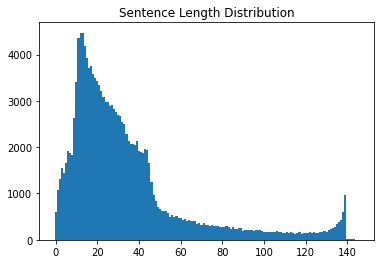

In [8]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [9]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_raw, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [10]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 2000:
        print("Outlier Index:", idx+1)

Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40


In [11]:
check_sentence_with_length(train_raw, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 146183
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


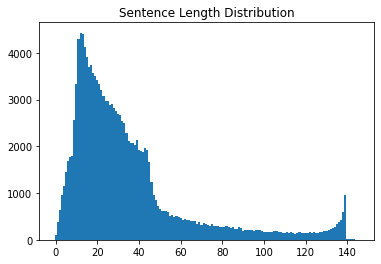

In [12]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#### (3) SentencePiece용 전처리

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


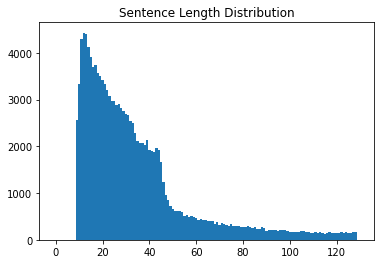

In [13]:
max_len = 130
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 2) SentencePiece 모델 학습

#### (1) 함수 구현

In [14]:
def SP_model_train(Mtype, vocab_size):
  temp_file = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/sp_tokenizer/data/ratings_train.txt.temp'

  with open(temp_file, 'w') as f:
      for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
          f.write(str(row) + '\n')

  if Mtype == 'bpe' or Mtype == 'unigram' or Mtype == 'char'or Mtype == 'word':
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix=korean_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, Mtype)    
    )
  else:
    print("Mtype를 잘 못 입력 했습니다 'bpe', 'unigram', 'char', 'word' 중 하나를 입력해주세요")
    if __name__ == "__main__": # 참조 : https://www.delftstack.com/ko/howto/python/python-exit-if-statement/
      load_data(0)  
      print("Broken out")
  
  #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.



#### (2) model_type, vocab_size 실험 및 모델 학습

> SentencePiece model_type : https://data-make.tistory.com/692
<br><br>LMS에서는 unigram, bpe만 소개해했지만 해당 링크에서는 여기에 char, word를 추가로 소개해주고 있다. 따라서 나는 이 두개도 추가해서 실험해 볼 예정이다.

In [15]:
# SP_model_train('unigram', 8000)
# SP_model_train('bpe', 8000)
# SP_model_train('char', 8000)
# SP_model_train('word', 8000)
SP_model_train('char', 16000)

In [16]:
!ls -l korean_spm*
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

-rw-r--r-- 1 root root 258138 Sep 25 11:02 korean_spm.model
-rw-r--r-- 1 root root  21876 Sep 25 11:02 korean_spm.vocab


True

#### (3) model_type, vocab_size 실험결과

> LMS에서 소개하지 않은 char 모델이 가장 좋은 정확도를 보여주고 있는 것을 확인했다. vocab_size의 경우는 8000보다는 16000으로 했을 때 accuracy는 차이가 없지만 loss가 더 떨어진 것을 확인할 수 있었다. <br><br> **결론은 char, 16000을 사용**하기로 한다.

- unigram, 8000
  - 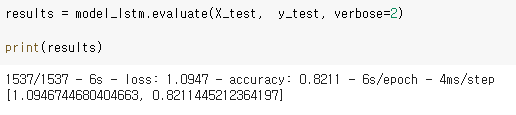
- bpe, 8000
  - 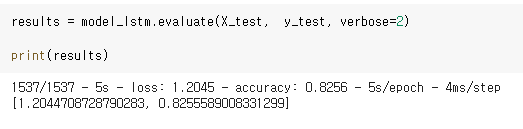
- char, 8000
  - 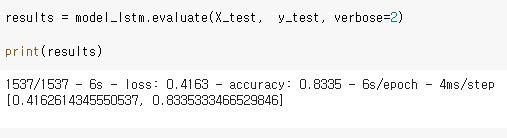
- word, 8000
  - 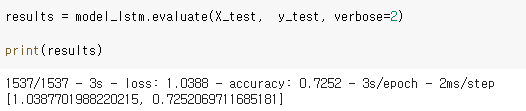
- char, 16000
  - 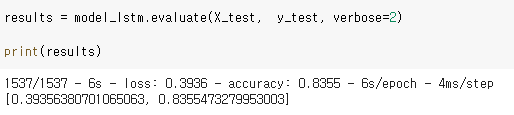

### 3) Tokenizer 및 load_data

#### (1) Tokenizer
- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하다

In [17]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

- 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

- 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

- 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

#### (2) load_data

In [18]:
def load_data(train_data, test_data):

    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    X_train, word_index, index_word = sp_tokenize(s,list(map(str,train_data['document']))) # 토큰화

    X_test, word_index, index_word = sp_tokenize(s,list(map(str,test_data['document']))) # 토큰화

        
    return np.array(list(X_train)), np.array(list(train_data['label'])), np.array(list(X_test)), np.array(list(test_data['label']))  

X_train, y_train, X_test, y_test= load_data(train_data, test_data) 

# validation set 10000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]


# validation set을 제외한 나머지 15000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

(96182, 147)
(96182,)
(50000, 147)
(50000,)
훈련 샘플 개수: 146182, 테스트 개수: 49157


### 4) 모델 설계 및 학습

#### (1) 모델 설계

In [19]:
vocab_size = 8000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 130  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 130)         1040000   
                                                                 
 lstm (LSTM)                 (None, 16)                9408      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,049,697
Trainable params: 1,049,697
Non-trainable params: 0
_________________________________________________________________


#### (2) 모델 학습

In [20]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 11s 21ms/step - loss: 0.5179 - accuracy: 0.7518 - val_loss: 0.4445 - val_accuracy: 0.7959
Epoch 2/20
188/188 [==============================] - 3s 18ms/step - loss: 0.4318 - accuracy: 0.8021 - val_loss: 0.4208 - val_accuracy: 0.8067
Epoch 3/20
188/188 [==============================] - 3s 18ms/step - loss: 0.4090 - accuracy: 0.8119 - val_loss: 0.4063 - val_accuracy: 0.8123
Epoch 4/20
188/188 [==============================] - 4s 19ms/step - loss: 0.3902 - accuracy: 0.8217 - val_loss: 0.3942 - val_accuracy: 0.8182
Epoch 5/20
188/188 [==============================] - 3s 18ms/step - loss: 0.3739 - accuracy: 0.8307 - val_loss: 0.3874 - val_accuracy: 0.8243
Epoch 6/20
188/188 [==============================] - 4s 19ms/step - loss: 0.3593 - accuracy: 0.8392 - val_loss: 0.3799 - val_accuracy: 0.8281
Epoch 7/20
188/188 [==============================] - 4s 19ms/step - loss: 0.3470 - accuracy: 0.8464 - val_loss: 0.3818 - val_accuracy: 0.826

#### (3) val과 train 그래프 확인

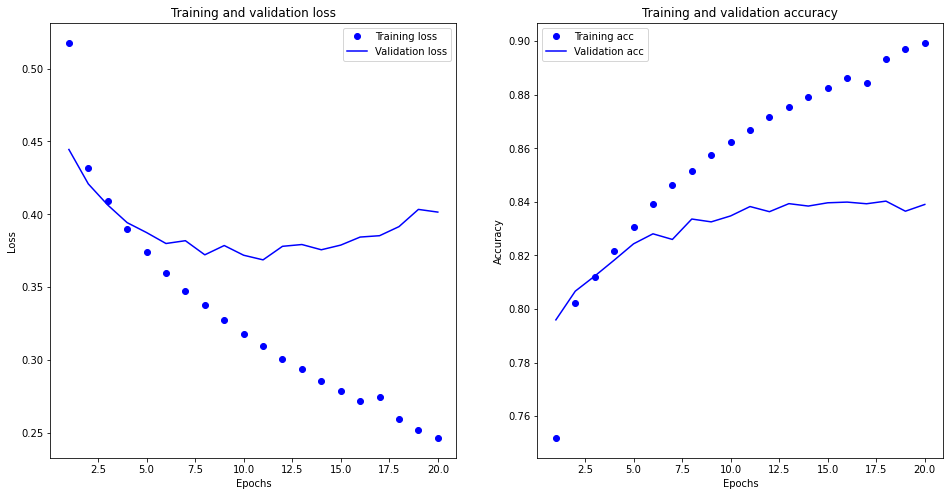

In [21]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

#### (4) 모델 학습 결과 확인

In [22]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.4054 - accuracy: 0.8381 - 6s/epoch - 4ms/step
[0.40540724992752075, 0.838090181350708]


## 3. Konlpy(feat.Mecab) 분석
> Konlpy에는 Hannanum, Kkma, Komoran, Mecab, Okt가 있다. 이 중에서 10만 단어를 기준으로 했을 때 속도 측면에서 가장 뛰어난 분석기는 Mecab이다. 다른 분석기에 비해서 성능이 압도적이다. 하지만 속도만 빠르면 안된다 리뷰 데이터와 같은 SNS성격이 띈 데이터에게 강한 분석기는 mecab와 Kkma가 있다. 하지만 Kkma는 시간이 너무 오래걸리는 **Macab를 사용하는 것이 가장 합리적**이다.

- 성능분석 자료 : https://iostream.tistory.com/144

### 1) 데이터 다운로드

In [23]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


Mtrain_data = pd.read_table('ratings_train.txt')
Mtest_data = pd.read_table('ratings_test.txt')


### 2) 데이터 전처리


In [25]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(Mtrain_data, Mtest_data)

In [26]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [27]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 데이터 분석 및 가공

In [28]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [31]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [32]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [33]:
# validation set 10000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


### 4) 모델 구현(SentencePiece분석과 동일한 구현으로 하여 성능 분석비교)

In [34]:
vocab_size = 8000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 130  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 130)         1040000   
                                                                 
 lstm_1 (LSTM)               (None, 16)                9408      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,049,697
Trainable params: 1,049,697
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 학습

In [35]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 10ms/step - loss: 0.4498 - accuracy: 0.7992 - val_loss: 0.3533 - val_accuracy: 0.8478
Epoch 2/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3302 - accuracy: 0.8592 - val_loss: 0.3434 - val_accuracy: 0.8503
Epoch 3/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3016 - accuracy: 0.8736 - val_loss: 0.3416 - val_accuracy: 0.8520
Epoch 4/20
188/188 [==============================] - 1s 8ms/step - loss: 0.2793 - accuracy: 0.8839 - val_loss: 0.3441 - val_accuracy: 0.8517
Epoch 5/20
188/188 [==============================] - 1s 8ms/step - loss: 0.2580 - accuracy: 0.8932 - val_loss: 0.3485 - val_accuracy: 0.8529
Epoch 6/20
188/188 [==============================] - 1s 8ms/step - loss: 0.2367 - accuracy: 0.9012 - val_loss: 0.3626 - val_accuracy: 0.8505
Epoch 7/20
188/188 [==============================] - 1s 8ms/step - loss: 0.2178 - accuracy: 0.9096 - val_loss: 0.3874 - val_accuracy: 0.8511
Epoch

### 6) 학습 결과 그래프

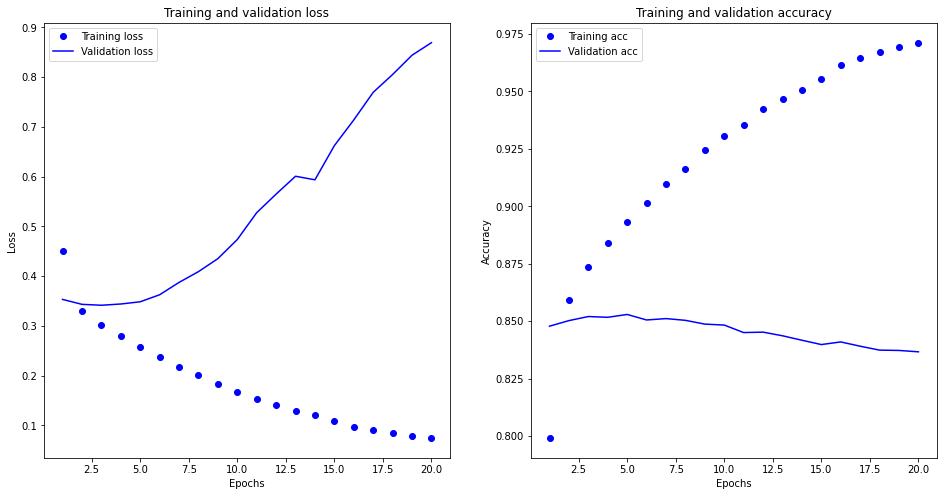

In [36]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

### 7) 모델 학습 결과 확인(test accuracy)

In [38]:
results_mecab = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_mecab)

1537/1537 - 3s - loss: 0.8840 - accuracy: 0.8314 - 3s/epoch - 2ms/step
[0.8839556574821472, 0.8313770294189453]


## 4.Konlpy(Mecab)와 SentencePiece 성능 비교

### 1) val, train의 그래프 비교

- SentencePiece
  - 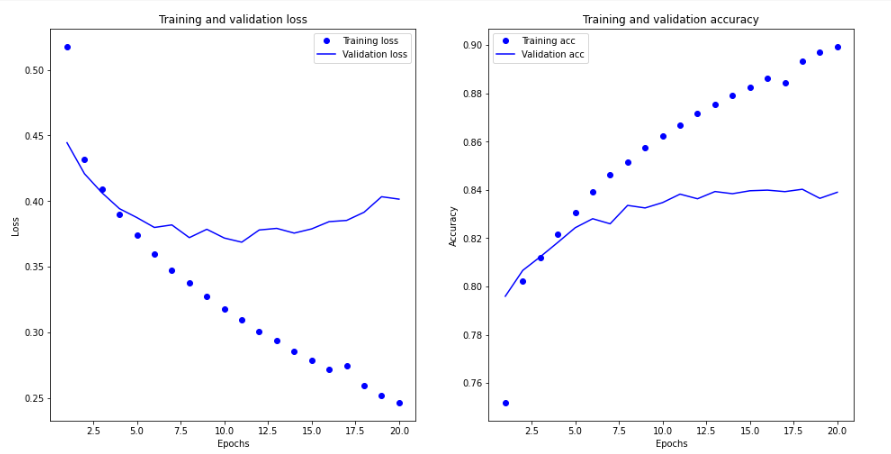

- Konlpy(Mecab)
  - 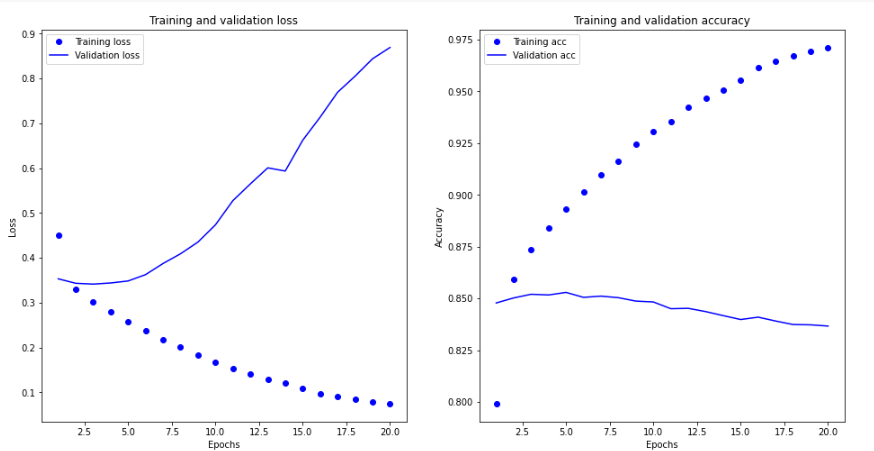

### 2) test accuracy 비교

- SentencePiece
  - 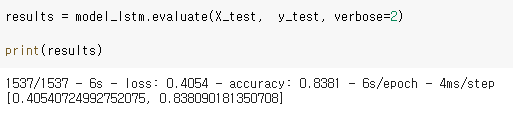
- Konlpy(Mecab)
  - 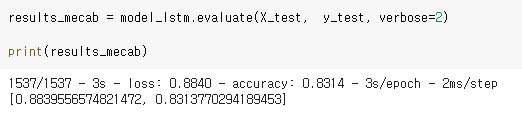

### 3) 결과 비교
- 그래프
  - SentencePiece의 val loss는 우하향, val accuracy는 우상향의 경향을 보인다.
  - 반면 Konlp는 val loss는 우상향, val accuracy는 우하향의 성능을 보인다.
  - 즉, Konlp의 경우는 과적합의 문제가 보여 SentencePiece가 더 뛰어난 성능을 보인다.
- test accuracy
  - SentencePiece의 loss는 0,40, accuracy는 0.8381
  - Konlpy(Mecab)의 loss는 0.88, accuracy는 0.8314
  - 즉, loss는 SentencePiece가 월등히 뛰어난 성능을 보여주고 있고 accuracy의 성능의 차이는 거의 미미한 것으로 보인다. 하지만 Mecab는 val값을 보았을 때 과적합으로 추정된다.
- 고려사항
  - 전처리 과정에서 조금 다른 결과를 낼 수 있다고 생각한다. Mecab 전처리를 조금 더 디테일하게 조정하면 성능이 더 좋아질지도 모른다. 
  - 하지만 두 분석기 모두 기본 전처리 기법을 사용하였기 때문에 이것을 감안한다면 결론은 SentencePiece가 더 좋은 성능을 보여주고 있다.
  - 다른분들의 결과도 함께 비교해보면 좋을 듯 하다.

## 5. 회고

- 어려웠던 점
  - SentencePiece 모델 학습과 load_data를 하나의 함수로 만들려고 시도를 해보았지만 코드가 꼬여서 실패했다.
  - 여러가지 경우의 수를 두고 시도를 하다보니 시간이 많이 걸렸다.
- 루브릭 조건을 맞추기 위해서 시도한 점
  - LSM에 나와있는 SentencePiece 모델을 분석, 전처리 등을 통해서 학습을 시켰다.
    - 문장 길이가 짧은 데이터는 감정을 분석할 수 없는 불필요한 단어가 많기 때문에 길이 10미만은 제거하였다.
    - 그래프를 확인했을 때 쌍봉으로 나왔는데 문자길이가 긴쪽에 생긴 봉우리는 제거하고 분석을 진행하였다.
  - test accuracy가 80% 이상이 나왔다.
    - 처음에는 padding를 post로 해서 성능이 좋지 않았지만 pre로 하니까 성능이 올라간 것을 확인할 수 있었다. 
    - RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하다
  - 다양한 시도와 비교분석을 진행하였다.
    - sentencePiece의 4가지 모델 옵션과 8000과 16000이라는 두 경우의 vocab_size를 가지고 실험을 했다.
    - 그리고 SentencePiece 뿐만 아니라 konlpy의 Mecab를 사용하여 비교분석을 진행하였다.
- 결론 
  - 다른 사람의 결과도 확인해봐야 겠지만 나의 코드에서는 SentencePiece가 더 좋은 성능을 보여주고 있다.

## 루브릭 조건

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
  - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
  - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
  
3. SentencePiece의 성능을 다각도로 비교분석하였는가?
  - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.